# Shallow Bayesian predictive coding networks

Here we invesigate Bayesian PCNs consisting only of a single "hidden" layer. We will extend the standard PCN appraoch to a full Bayesian treatment of PCNs. Unlike PCNs where inference and learning relies on MAP estimates for latent variables and MLE estimate for weights, we will formulate Bayesian PCNs with defined prior over weights and the full estimate of the posterior of latent variables and weights.

The investigation is inspired by the following paper: "Illing, Bernd, Wulfram Gerstner, and Johanni Brea. "Biologically plausible deep learning—but how far can we go with shallow networks?." Neural Networks 118 (2019): 90-101". The authors were interested to understand the limitations of shallow networks for image classification, with the aim to test local biologically plaussible learning rules. PCNs result in learning rules that are local and hebbian like, and no backpropagation beween layers is necessary, hence one naturally obtains biologically plaussible learning.  

Here we will utilise the same paradigm of shallow networks, to test how Bayesian treatment of sparse PCNs changes the performance of classification algorithms. 

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
######################################################

In [2]:
import jax.numpy as jnp
from jax import random
from jax.nn import one_hot
from flax import linen as fnn
from typing import Any, Callable, Sequence

Shallow neural network

In [3]:
class DenseNet(fnn.Module):
  """A simple dense neural network."""

  features: Sequence[int]
  act: Callable

  @fnn.compact
  def __call__(self, x, **kwargs):
    x = fnn.Dense(features=self.features[0], name='dense0')(x)
    for i, f in enumerate(self.features[1:]):
        x = self.act(x)
        x = fnn.Dense(features=f, name='dense{}'.format(i+1))(x)
    
    return x

ShallowNet = lambda n, c: DenseNet([n, c], fnn.relu)

In [4]:
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.module import flax_module

def likelihood(nnet, images, labels, n, subsample_size):
    with numpyro.plate("N", n, subsample_size=subsample_size):
        batch_x = numpyro.subsample(images, event_dim=1)
        pred = nnet(batch_x)
        
        if labels is not None:
            batch_y = numpyro.subsample(labels, event_dim=0)
        else:
            batch_y = None
        
        numpyro.sample(
            "obs", dist.Categorical(logits=pred), obs=batch_y
        )
            
def shallownet(images, n_neurons=1, n_labels=10, labels=None, subsample_size=None):
    n, d = images.shape

    nnet = flax_module("nnet", ShallowNet(n_neurons, n_labels), input_shape=(1, d))

    likelihood(nnet, images, labels, n, subsample_size)

In [5]:
import optax
from numpyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, Predictive
def fitting_and_testing(model, train_ds, test_ds, rng_key, number_of_hidden_neurons, n_iter=10000):
    guide = lambda *args, **kwargs: None  # MLE estimate
    opt = optax.chain(
        optax.clip(100.),
        optax.adam(1e-3)
    )
    optimizer = numpyro.optim.optax_to_numpyro(opt)

    svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=1))
    #########################################

    rng_key, _rng_key = random.split(rng_key)

    svi_result = svi.run(
        _rng_key, 
        n_iter, 
        train_ds['image'],
        n_neurons=number_of_hidden_neurons, 
        labels=train_ds['label'], 
        subsample_size=256)

    params = svi_result.params

    pred = Predictive(model, params={**params}, num_samples=1)
    rng_key, _rng_key = random.split(rng_key)
    sample = pred(_rng_key, test_ds['image'], n_neurons=number_of_hidden_neurons)
    acc = jnp.mean(sample['obs'][0] == test_ds['label'] )
    
    print('model acc :', acc)
    
    return acc

In [6]:
from numpc.datasets import MNIST

# load data
train_ds, test_ds = MNIST()

train_ds['image'] = train_ds['image'].reshape(train_ds['image'].shape[0], -1)
test_ds['image'] = test_ds['image'].reshape(test_ds['image'].shape[0], -1)

In [7]:
num_hn = [10, 20, 40, 80, 160, 320, 640]

In [8]:
rng_key = random.PRNGKey(1001)

accs = []
for n_neurons in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    accs.append(fitting_and_testing(shallownet, train_ds, test_ds, _rng_key, n_neurons, n_iter=20000))

100%|█████████████████████████████████████| 20000/20000 [00:22<00:00, 880.05it/s, init loss: 140556.0625, avg. loss [19001-20000]: 10017.9873]


model acc : 0.9155


100%|██████████████████████████████████████| 20000/20000 [00:22<00:00, 881.97it/s, init loss: 139908.6406, avg. loss [19001-20000]: 4756.3457]


model acc : 0.94799995


100%|███████████████████████████████████████| 20000/20000 [00:22<00:00, 878.25it/s, init loss: 138753.6562, avg. loss [19001-20000]: 539.0934]


model acc : 0.965


100%|████████████████████████████████████████| 20000/20000 [00:22<00:00, 901.13it/s, init loss: 140794.8906, avg. loss [19001-20000]: 10.1806]


model acc : 0.9754


100%|█████████████████████████████████████████| 20000/20000 [00:22<00:00, 894.52it/s, init loss: 137953.7188, avg. loss [19001-20000]: 2.1186]


model acc : 0.9801


100%|█████████████████████████████████████████| 20000/20000 [00:21<00:00, 950.39it/s, init loss: 141077.8750, avg. loss [19001-20000]: 0.7684]


model acc : 0.98139995


100%|█████████████████████████████████████████| 20000/20000 [00:21<00:00, 933.92it/s, init loss: 140340.1875, avg. loss [19001-20000]: 0.0672]


model acc : 0.98319995


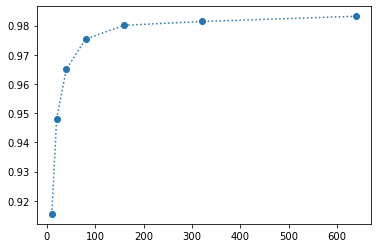

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(num_hn, accs, 'o:');

## Bayesian shallow neural network

In [8]:
from numpyro.contrib.module import random_flax_module

def bayes_shallownet(images, n_neurons=1, n_labels=10, labels=None, subsample_size=None):
    n, d = images.shape
    
    prior = {"dense0.bias": dist.Cauchy(), 
             "dense0.kernel": dist.Normal(0., 1.),
             "dense1.bias":dist.Cauchy(),
             "dense1.kernel": dist.Normal(0., 1.)
            }
    nnet = random_flax_module('nnet', ShallowNet(n_neurons, n_labels), prior, input_shape=(1, d))

    likelihood(nnet, images, labels, n, subsample_size)

In [9]:
from numpyro.infer.autoguide import AutoDelta, AutoNormal
from jax import device_put, devices

def optimizer():    
    def is_nn_param_fn(params):
        # returns dict with true or false values depending on
        # whether parameter belongs to states or to neural networks
        out = {}
        for name in params:
            if 'nnet' in name:
                out[name] = True
            else:
                out[name] = False
        return out

    def not_nn_param_fn(params):
        # returns dict with true or false values depending on
        # whether parameter belongs to states or to neural networks
        out = {}
        for name in params:
            if 'nnet' in name:
                out[name] = False
            else:
                out[name] = True
        return out

    optax_optim = optax.chain(
        optax.masked(optax.adam(1e-2), not_nn_param_fn),
        optax.masked(optax.chain(optax.clip(100.), optax.adam(1e-4)), is_nn_param_fn)
    )
    return numpyro.optim.optax_to_numpyro(optax_optim)

def bayes_fitting_and_testing(model, train_ds, test_ds, rng_key, number_of_hidden_neurons, n_iter=10000, approx='delta'):
    if approx == 'mean-field':
        guide = AutoNormal(model) # Mean-feald estimate
    else:
        guide = AutoDelta(model)  # MAP estimate

    opt = optax.chain(
        optax.clip(100.),
        optax.adam(1e-3)
    )
    optimizer = numpyro.optim.optax_to_numpyro(opt)
    if approx == 'mean-feald':
        svi = SVI(model, guide, optimizer, loss=TraceMeanField_ELBO(num_particles=1))
    else:
        svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=1))
    #########################################

    rng_key, _rng_key = random.split(rng_key)

    svi_result = svi.run(
        _rng_key, 
        n_iter, 
        train_ds['image'],
        n_neurons=number_of_hidden_neurons, 
        labels=train_ds['label'], 
        subsample_size=256)

    params = svi_result.params
    params = device_put(params, devices('cpu')[0])  
    
    if approx == 'delta':
        pred = Predictive(model, guide=guide, params={**params}, num_samples=1)
        rng_key, _rng_key = random.split(rng_key)
        sample = pred(_rng_key, test_ds['image'], n_neurons=number_of_hidden_neurons)
        acc = jnp.mean(sample['obs'][0] == test_ds['label'] )
    else:
        pred = Predictive(model, guide=guide, params={**params}, num_samples=1000)
        rng_key, _rng_key = random.split(rng_key)
        sample = pred(_rng_key, test_ds['image'], n_neurons=number_of_hidden_neurons)
        pred_labels = one_hot(sample['obs'], 10).mean(0).argmax(-1)
        acc = jnp.mean(pred_labels == test_ds['label'] )
        
    print('model acc :', acc)
    
    return acc

In [12]:
rng_key = random.PRNGKey(102301)

num_hn = [10, 20, 40, 80, 160, 320, 640]
bayes_accs = []
for n_neurons in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    bayes_accs.append(
        bayes_fitting_and_testing(bayes_shallownet, train_ds, test_ds, _rng_key, n_neurons, n_iter=20000)
    )

100%|█████████████████████████████████████| 20000/20000 [00:22<00:00, 895.32it/s, init loss: 276783.5000, avg. loss [19001-20000]: 18640.1699]


model acc : 0.9151


100%|█████████████████████████████████████| 20000/20000 [00:22<00:00, 887.75it/s, init loss: 330147.5312, avg. loss [19001-20000]: 20111.6016]


model acc : 0.94619995


100%|█████████████████████████████████████| 20000/20000 [00:21<00:00, 921.85it/s, init loss: 399624.1875, avg. loss [19001-20000]: 31221.2129]


model acc : 0.9651


100%|█████████████████████████████████████| 20000/20000 [00:22<00:00, 884.62it/s, init loss: 547406.6875, avg. loss [19001-20000]: 59541.8594]


model acc : 0.97349995


100%|████████████████████████████████████| 20000/20000 [00:23<00:00, 865.94it/s, init loss: 889882.3125, avg. loss [19001-20000]: 117950.3516]


model acc : 0.97709996


100%|███████████████████████████████████| 20000/20000 [00:21<00:00, 918.40it/s, init loss: 1120827.6250, avg. loss [19001-20000]: 235290.0938]


model acc : 0.97779995


100%|███████████████████████████████████| 20000/20000 [00:22<00:00, 898.09it/s, init loss: 2071813.6250, avg. loss [19001-20000]: 469827.8438]


model acc : 0.97639996


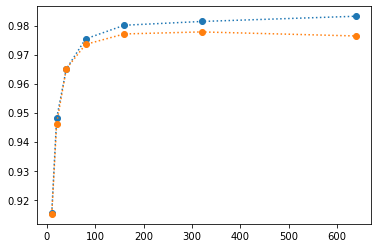

In [13]:
plt.plot(num_hn, accs, 'o:');
plt.plot(num_hn, bayes_accs, 'o:');

## Sparse Bayesian shallow neural network

In [10]:
def sparse_bayes_shallownet(images, n_neurons=1, n_labels=10, labels=None, subsample_size=None):
    '''Generative model based on the following paper
    Ghosh, Soumya, and Finale Doshi-Velez. 
    "Model selection in Bayesian neural networks via horseshoe priors." 
    arXiv preprint arXiv:1705.10388 (2017).
    '''
    n, d = images.shape
    
    bar_t0 = numpyro.sample('bar_t0', dist.InverseGamma(1/2, 1.))
    til_t0 = numpyro.sample('til_t0', dist.InverseGamma(1/2, 1.))
    tau0 = numpyro.deterministic('tau0', til_t0/bar_t0)
    
    bar_l0 = numpyro.sample('bar_l0', dist.InverseGamma(1/2, 1.).expand([n_neurons]).to_event(1))
    til_l0 = numpyro.sample('til_l0', dist.InverseGamma(1/2, 1.).expand([n_neurons]).to_event(1))
    lam0 = numpyro.deterministic('lam0', til_l0/bar_l0)
    
    b_1 = 5.
    bar_l1 = numpyro.sample('bar_l1', dist.InverseGamma(1/2, 1.).expand([n_labels]).to_event(1))
    til_l1 = numpyro.sample('til_l1', dist.InverseGamma(1/2, 1.).expand([n_labels]).to_event(1))
    lam1 = numpyro.deterministic('lam1', b_1**2 * til_l1 / bar_l1)
    
    prior = {"dense0.bias": dist.Cauchy(), 
             "dense0.kernel": dist.Normal(0., lam0 * tau0),
             "dense1.bias": dist.Cauchy(),
             "dense1.kernel": dist.Normal(0., lam1)
            }
    nnet = random_flax_module('nnet', ShallowNet(n_neurons, n_labels), prior, input_shape=(1, d))

    likelihood(nnet, images, labels, n, subsample_size)

In [11]:
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {
    "nnet/dense0.kernel": LocScaleReparam(0),
    "nnet/dense1.kernel": LocScaleReparam(0),
}
reparam_model = reparam(
    sparse_bayes_shallownet, config=reparam_config
)

In [24]:
rng_key = random.PRNGKey(10234501)

sparse_accs = []
for n_neurons in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    sparse_accs.append(
        bayes_fitting_and_testing(reparam_model, train_ds, test_ds, _rng_key, n_neurons, n_iter=20000)
    )

100%|████████████████████████████████████| 20000/20000 [00:28<00:00, 706.58it/s, init loss: 6788181.5000, avg. loss [19001-20000]: 19180.7305]


model acc : 0.9066


100%|███████████████████████████████████| 20000/20000 [00:28<00:00, 693.54it/s, init loss: 27533396.0000, avg. loss [19001-20000]: 21490.5234]


model acc : 0.9402


100%|███████████████████████████████████| 20000/20000 [00:28<00:00, 692.37it/s, init loss: 17412846.0000, avg. loss [19001-20000]: 32853.9805]


model acc : 0.95769995


100%|██████████████████████████████████| 20000/20000 [00:28<00:00, 697.69it/s, init loss: 349221536.0000, avg. loss [19001-20000]: 60702.5742]


model acc : 0.9659


100%|█████████████████████████████████| 20000/20000 [00:28<00:00, 690.62it/s, init loss: 107993264.0000, avg. loss [19001-20000]: 120244.8906]


model acc : 0.9715


100%|█████████████████████████████████| 20000/20000 [00:29<00:00, 680.33it/s, init loss: 175932896.0000, avg. loss [19001-20000]: 238960.7656]


model acc : 0.97249997


100%|████████████████████████████████| 20000/20000 [00:30<00:00, 645.47it/s, init loss: 5619810304.0000, avg. loss [19001-20000]: 477615.9375]


model acc : 0.9748


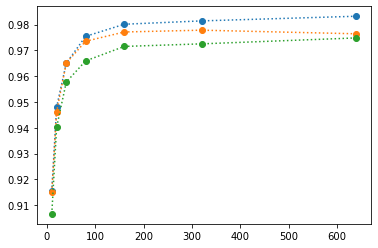

In [25]:
plt.plot(num_hn, accs, 'o:');
plt.plot(num_hn, bayes_accs, 'o:');
plt.plot(num_hn, sparse_accs, 'o:');

In [12]:
rng_key = random.PRNGKey(102348221)
sparse_accs = []
for n_neurons in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    sparse_accs.append(
        bayes_fitting_and_testing(reparam_model, train_ds, test_ds, _rng_key, n_neurons, n_iter=20000, approx='mean-field')
    )

100%|█████████████████████████████████| 20000/20000 [00:44<00:00, 449.69it/s, init loss: 6329416192.0000, avg. loss [19001-20000]: 23661.5938]


model acc : 0.9194


100%|██████████████████████████████████| 20000/20000 [00:44<00:00, 447.38it/s, init loss: 855923520.0000, avg. loss [19001-20000]: 20282.6289]


model acc : 0.94909996


100%|██████████████████████████████████| 20000/20000 [00:44<00:00, 447.32it/s, init loss: 474137024.0000, avg. loss [19001-20000]: 22101.1738]


model acc : 0.96459997


100%|█████████████████████████████████| 20000/20000 [00:46<00:00, 432.80it/s, init loss: 3717707776.0000, avg. loss [19001-20000]: 66037.8438]


model acc : 0.959


100%|█████████████████████████████████| 20000/20000 [00:48<00:00, 413.54it/s, init loss: 437753216.0000, avg. loss [19001-20000]: 399303.5938]


model acc : 0.9536


100%|███████████████████████████████| 20000/20000 [00:46<00:00, 426.38it/s, init loss: 12485942272.0000, avg. loss [19001-20000]: 572157.0625]


model acc : 0.9636


100%|████████████████████████████████| 20000/20000 [00:48<00:00, 414.85it/s, init loss: 7574020096.0000, avg. loss [19001-20000]: 300416.7812]


model acc : 0.9748


NOTE: Test in another notebook how changing the model structure into something similar to causal network changes the problem.